# Table of Content

1. **Task**
2. **Data Preprocessing**
   - 2.a Convert Categorical Variables (Yes/No)
   - 2.b Remove Constant Variables
   - 2.c Handle Categorical Variables
3. **Model Assessment with 5-Fold Cross Validation**
4. **Constructing the CART Decision Tree**
   - 4.a Using `sklearn.tree.DecisionTreeClassifier`
   - 4.b Reporting Confusion Matrix
5. **Summarization of the Colab Notebook**

# What is Decision Tree Algorithm?
A decision tree is a supervised learning algorithm used for both classification and regression tasks. It builds a tree-like model of decisions and their possible consequences.

**Core Idea:**

The algorithm recursively splits the dataset into subsets based on the feature that provides the best information gain or reduction in impurity. This process continues until a stopping criterion is met, such as reaching a maximum tree depth or a minimum number of samples in a leaf node.

**Key Concepts:**

* **Entropy:** A measure of impurity or disorder in a dataset. A node with only one class has zero entropy, while a node with an equal number of samples from each class has maximum entropy.
   ```
   Entropy(S) = - Σ (p_i * log2(p_i))
   ```
   where `p_i` is the proportion of samples belonging to class `i` in the dataset `S`.
* **Information Gain:** The reduction in entropy achieved by splitting a dataset based on a particular feature.
   ```
   InformationGain(S, A) = Entropy(S) - Σ [(|S_v| / |S|) * Entropy(S_v)]
   ```
   where `S` is the dataset, `A` is the feature, `S_v` is the subset of `S` where feature `A` has value `v`, and `|S|` denotes the number of samples in `S`.
* **Gini Impurity:** Another measure of impurity, used in the CART (Classification and Regression Trees) algorithm. It calculates the probability of misclassifying a randomly chosen element if it were randomly labeled according to the class distribution in the dataset.
   ```
   Gini(S) = 1 - Σ (p_i)^2
   ```
   where `p_i` is the proportion of samples belonging to class `i` in the dataset `S`.


**Decision Tree Construction:**

1. **Select the best feature:** Choose the feature that maximizes information gain or minimizes Gini impurity.
2. **Split the dataset:** Divide the dataset into subsets based on the chosen feature's values.
3. **Recursively repeat steps 1 and 2:** Apply the process to each subset until a stopping criterion is met.
4. **Create leaf nodes:** Assign a class label to each leaf node based on the majority class of the samples it contains (for classification).

**Advantages:**

* Easy to understand and interpret.
* Can handle both numerical and categorical data.
* Requires less data preprocessing compared to some other algorithms.

**Disadvantages:**

* Prone to overfitting if the tree is too deep.
* Can be unstable, as small changes in the data can lead to different tree structures.
* May not be optimal for datasets with many continuous features.


**Note:** Decision trees are a fundamental building block for more complex ensemble methods, such as random forests and gradient boosting.

# Task

1.Given the dataset, construct the CART decision tree using GINI criterion to predict Employee Attrition (1= positive, 0=negative)

2.Data Preprocessing:

     a. Convert the category class Yes / No into 1 and 0, respectively.
        https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

     b. Remove variables that do not change across the observation.

     c. Handle all seven categorical variables.

3.Model assessment with 5-fold cross validation.

4.Use sklearn.tree.DecisionTreeClassifier to construct the first decision tree CART with the default values of hyperparameters.
         https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html
   
   Report Confusion Matrix of the model performance.

# Import Library

In [ ]:
import pandas as pd
import re
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import KFold, cross_val_score, cross_val_predict
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load Data

In [ ]:
url = "https://raw.githubusercontent.com/SKY-TKP/AI-ENG/refs/heads/main/dataset_week9.csv"
df = pd.read_csv(url)

In [ ]:
df.head()

,Attrition,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,Yes,21,Travel_Frequently,251,Research & Development,10,2,Life Sciences,1,1279,...,3,80,0,2,2,1,2,2,2,2
1,No,29,Travel_Rarely,1389,Research & Development,21,4,Life Sciences,1,20,...,3,80,1,10,1,3,10,9,8,8
2,No,55,Non-Travel,177,Research & Development,8,1,Medical,1,1278,...,4,80,1,34,3,3,33,9,15,0
3,No,46,Travel_Rarely,168,Sales,4,2,Marketing,1,1280,...,3,80,1,26,2,3,11,4,0,8
4,No,34,Travel_Rarely,131,Sales,2,3,Marketing,1,1281,...,4,80,0,4,3,3,3,2,0,2


## Histogram for each subplots

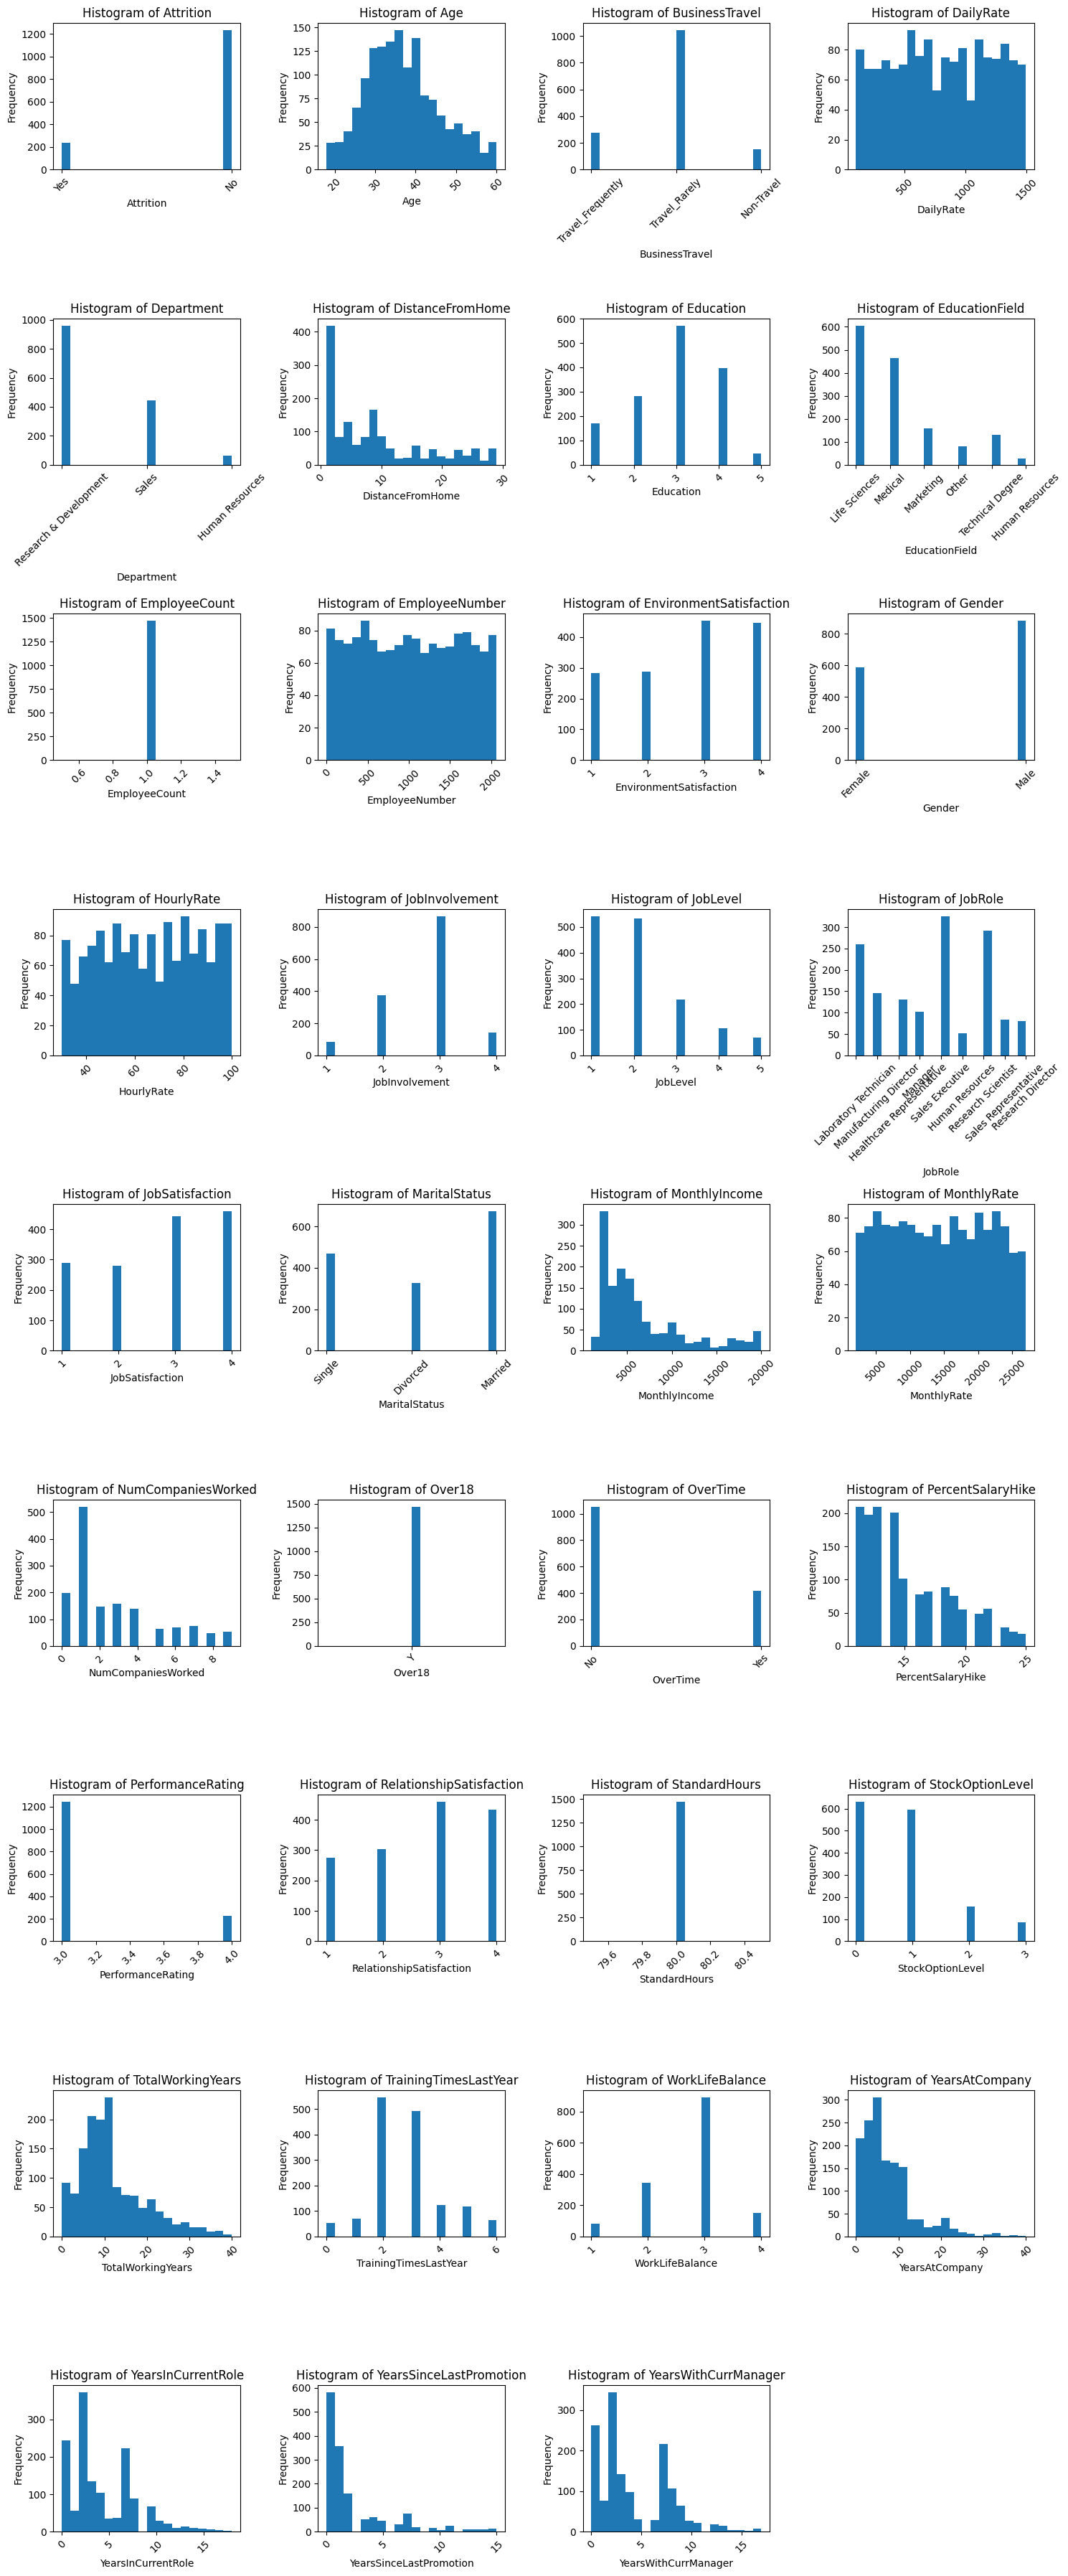

In [ ]:
# Create subplots for histograms
num_cols = len(df.columns)
rows = (num_cols + 3) // 4
cols = min(4, num_cols)

fig, axes = plt.subplots(rows, cols, figsize=(15, rows * 4))  # Adjust figure size

for i, col in enumerate(df.columns):
    row = i // cols
    col_index = i % cols
    ax = axes[row, col_index]

    ax.hist(df[col], bins=20)
    ax.set_title(f'Histogram of {col}')
    ax.set_xlabel(col)
    ax.set_ylabel('Frequency')
    ax.tick_params(axis='x', rotation=45)

# Remove any unused subplots
for i in range(num_cols, rows * cols):
    row = i // cols
    col_index = i % cols
    fig.delaxes(axes[row, col_index])

plt.tight_layout()
plt.show()

## Preprocessing

In [ ]:
# use LabelEncoder for label encoding classes to 0, 1
labenlencoder = LabelEncoder()
df["Attrition"] = labenlencoder.fit_transform(df["Attrition"])

In [ ]:
df.head()

,Attrition,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,...,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1,21,Travel_Frequently,251,Research & Development,10,2,Life Sciences,1,1279,...,3,80,0,2,2,1,2,2,2,2
1,0,29,Travel_Rarely,1389,Research & Development,21,4,Life Sciences,1,20,...,3,80,1,10,1,3,10,9,8,8
2,0,55,Non-Travel,177,Research & Development,8,1,Medical,1,1278,...,4,80,1,34,3,3,33,9,15,0
3,0,46,Travel_Rarely,168,Sales,4,2,Marketing,1,1280,...,3,80,1,26,2,3,11,4,0,8
4,0,34,Travel_Rarely,131,Sales,2,3,Marketing,1,1281,...,4,80,0,4,3,3,3,2,0,2


In [ ]:
# Remove variables that do not change across the observation (constant column)
drop_columns = df.columns[df.nunique() <= 1]
drop_columns

Index(['EmployeeCount', 'Over18', 'StandardHours'], dtype='object')

In [ ]:
df.drop(columns=drop_columns, inplace=True)

In [ ]:
df.select_dtypes(include=['object'])

,BusinessTravel,Department,EducationField,Gender,JobRole,MaritalStatus,OverTime
0,Travel_Frequently,Research & Development,Life Sciences,Female,Laboratory Technician,Single,No
1,Travel_Rarely,Research & Development,Life Sciences,Female,Manufacturing Director,Divorced,No
2,Non-Travel,Research & Development,Medical,Male,Healthcare Representative,Divorced,Yes
3,Travel_Rarely,Sales,Marketing,Female,Manager,Married,No
4,Travel_Rarely,Sales,Marketing,Female,Sales Executive,Single,Yes
...,...,...,...,...,...,...,...
1465,Travel_Rarely,Sales,Medical,Male,Sales Executive,Divorced,No
1466,Travel_Rarely,Research & Development,Medical,Male,Laboratory Technician,Single,No
1467,Travel_Rarely,Research & Development,Life Sciences,Male,Healthcare Representative,Married,No
1468,Non-Travel,Research & Development,Medical,Female,Healthcare Representative,Divorced,No


In [ ]:
# Assuming 'df' is your DataFrame and you want to sort by a specific column, e.g., 'Age'
sorted_df = df.sort_values(by=['Age'])

# Display the sorted DataFrame
sorted_df

,Attrition,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
1009,0,18,Non-Travel,1124,Research & Development,1,3,Life Sciences,1368,4,...,3,3,0,0,5,4,0,0,0,0
1205,1,18,Travel_Frequently,544,Sales,3,2,Medical,1624,2,...,3,3,0,0,2,4,0,0,0,0
256,1,18,Travel_Frequently,1306,Sales,5,3,Marketing,614,2,...,3,4,0,0,3,3,0,0,0,0
876,1,18,Non-Travel,247,Research & Development,8,1,Medical,1156,3,...,3,4,0,0,0,3,0,0,0,0
781,0,18,Non-Travel,287,Research & Development,5,2,Life Sciences,1012,2,...,3,4,0,0,2,3,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
226,0,60,Travel_Frequently,1499,Sales,28,3,Marketing,573,3,...,3,4,0,22,5,4,18,13,13,11
210,0,60,Travel_Rarely,422,Research & Development,7,3,Life Sciences,549,1,...,3,4,0,33,5,1,29,8,11,10
335,0,60,Travel_Rarely,1179,Sales,16,4,Marketing,732,1,...,3,4,0,10,1,3,2,2,2,2
933,0,60,Travel_Rarely,696,Sales,7,4,Marketing,1233,2,...,3,2,1,12,3,3,11,7,1,9


In [ ]:
# use LabelEncoder handle all seven categorical variables
categorical_columns = df.select_dtypes(include = ['object']).columns.tolist()

for col in categorical_columns:
  print(f"Column: {col}")
  le = LabelEncoder()
  df[col] = le.fit_transform(df[col]) # convert to encoder
  print(f"  Unique values before encoding: {df[col].sort_values().unique()}")
  print(f"  Unique values after encoding: {le.classes_}")
  print("-" * 20)

#for col in categorial_columns:
#  df[col] = LabelEncoder.fit_transform(df[col])

Column: BusinessTravel
  Unique values before encoding: [0 1 2]
  Unique values after encoding: ['Non-Travel' 'Travel_Frequently' 'Travel_Rarely']
--------------------
Column: Department
  Unique values before encoding: [0 1 2]
  Unique values after encoding: ['Human Resources' 'Research & Development' 'Sales']
--------------------
Column: EducationField
  Unique values before encoding: [0 1 2 3 4 5]
  Unique values after encoding: ['Human Resources' 'Life Sciences' 'Marketing' 'Medical' 'Other'
 'Technical Degree']
--------------------
Column: Gender
  Unique values before encoding: [0 1]
  Unique values after encoding: ['Female' 'Male']
--------------------
Column: JobRole
  Unique values before encoding: [0 1 2 3 4 5 6 7 8]
  Unique values after encoding: ['Healthcare Representative' 'Human Resources' 'Laboratory Technician'
 'Manager' 'Manufacturing Director' 'Research Director'
 'Research Scientist' 'Sales Executive' 'Sales Representative']
--------------------
Column: MaritalStat

In [ ]:
df.head()

,Attrition,Age,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeNumber,EnvironmentSatisfaction,...,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,1,21,1,251,1,10,2,1,1279,1,...,4,3,0,2,2,1,2,2,2,2
1,0,29,2,1389,1,21,4,1,20,2,...,3,3,1,10,1,3,10,9,8,8
2,0,55,0,177,1,8,1,3,1278,4,...,3,4,1,34,3,3,33,9,15,0
3,0,46,2,168,2,4,2,2,1280,4,...,3,3,1,26,2,3,11,4,0,8
4,0,34,2,131,2,2,3,2,1281,3,...,3,4,0,4,3,3,3,2,0,2


In [ ]:
# split train test
x = df.drop(columns=['Attrition'])
y = df['Attrition']
x_train, x_test, y_train, y_test = train_test_split(x, y, stratify=y, test_size=0.20, random_state=101)

## Plot correlation_matrix for each group vs. Attrition

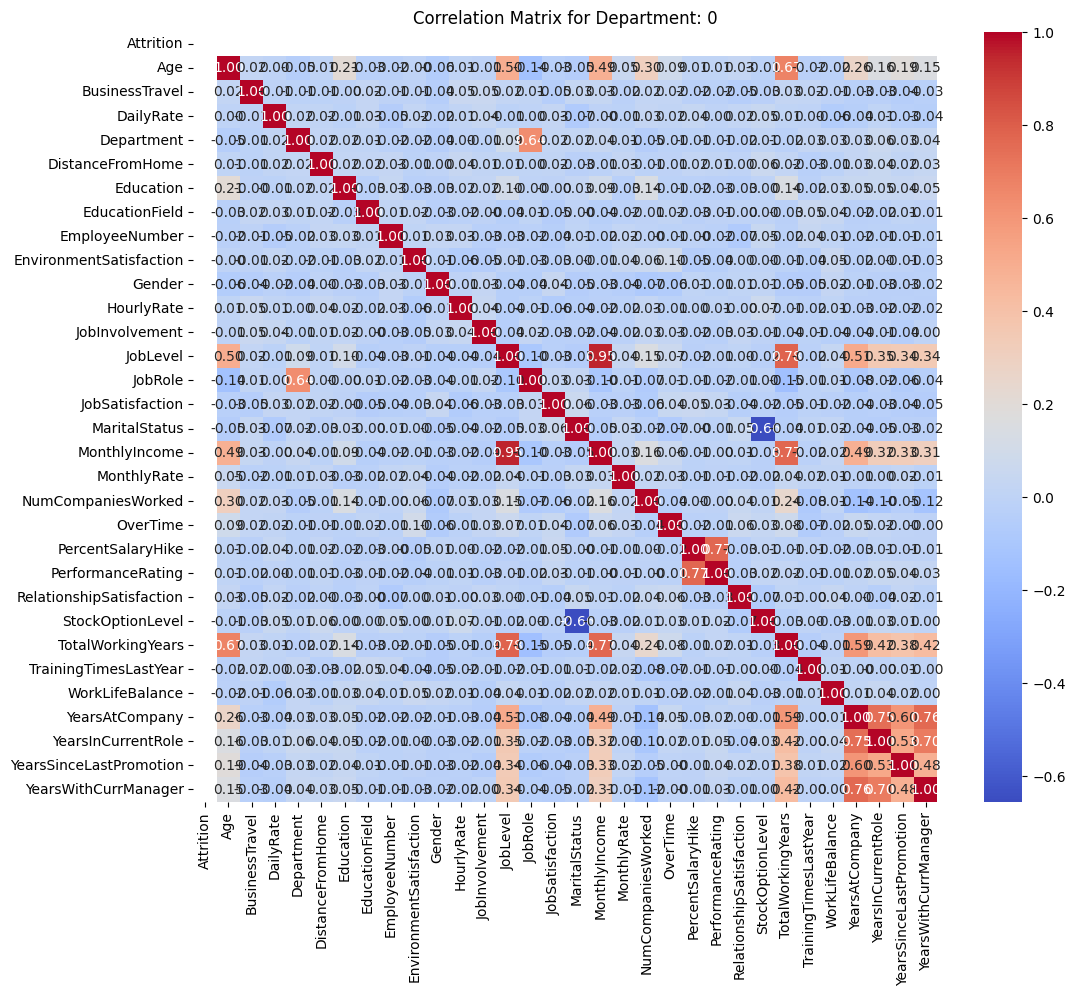

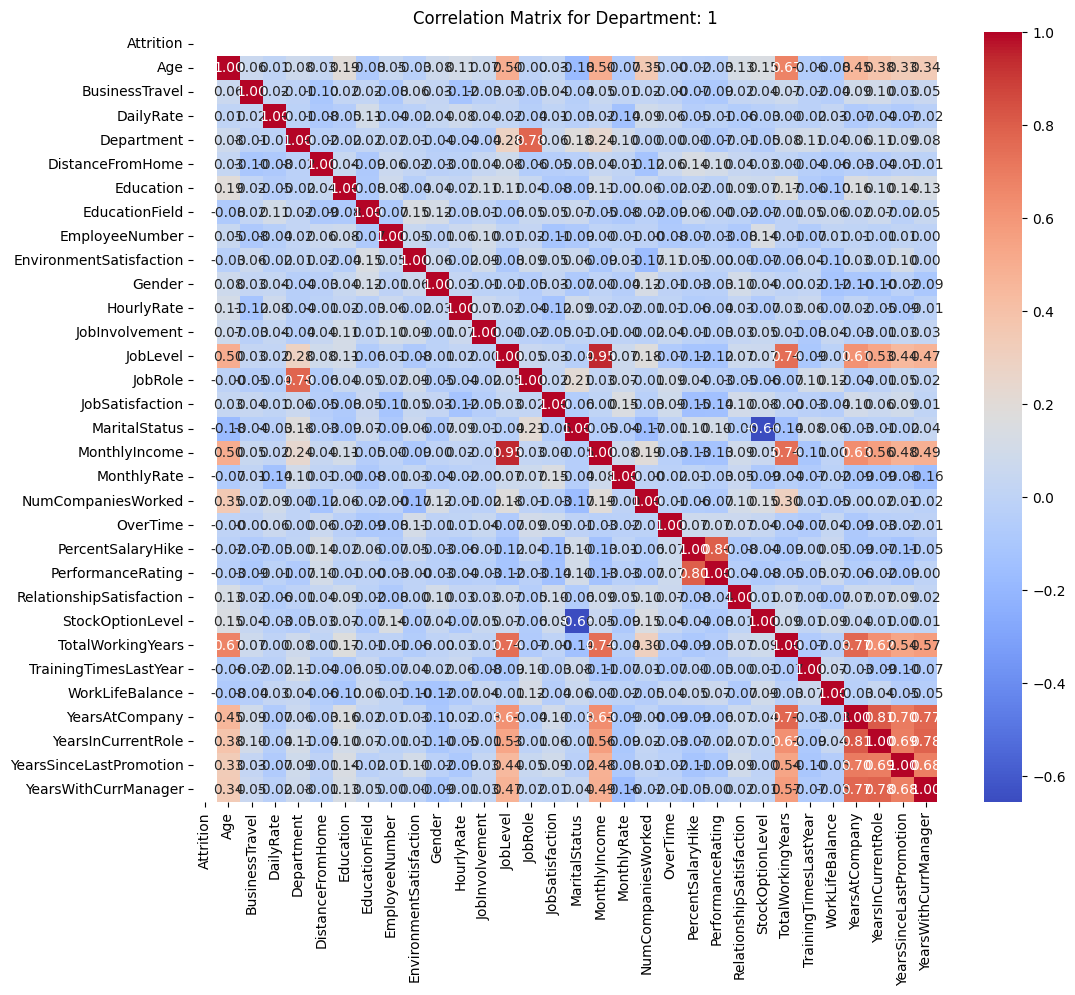

In [ ]:
for group_name, group_data in df.groupby('Attrition'):
  plt.figure(figsize=(12, 10))
  correlation_matrix = group_data.corr()
  sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
  plt.title(f'Correlation Matrix for Department: {group_name}')
  plt.show()

# Decision Tree Classifier

## Call Model

In [ ]:
dtree = DecisionTreeClassifier()

## Cross Validation

Model assessment with 5-fold cross validation.

In [ ]:
# Cross Validation
cv_scores = cross_val_score(dtree, x_train, y_train, cv=5)
dtree.fit(x_train, y_train)
dtree_y_pred = dtree.predict(x_test)

In [ ]:
print(f'Average Cross-Validation Accuracy: {cv_scores.mean():.5f}')

Average Cross-Validation Accuracy: 0.77636


In [ ]:
dtree_y_pred

array([0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0,
       1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 1, 1,
       0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0,
       0, 0, 1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1,
       0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0,
       1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0,
       0, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 1, 0, 0, 0, 0, 1, 0])

## Report Score

In [ ]:
print(classification_report(y_test, dtree_y_pred))

              precision    recall  f1-score   support

           0       0.87      0.83      0.85       247
           1       0.28      0.34      0.30        47

    accuracy                           0.75       294
   macro avg       0.57      0.59      0.58       294
weighted avg       0.77      0.75      0.76       294



## Confustion Matrix

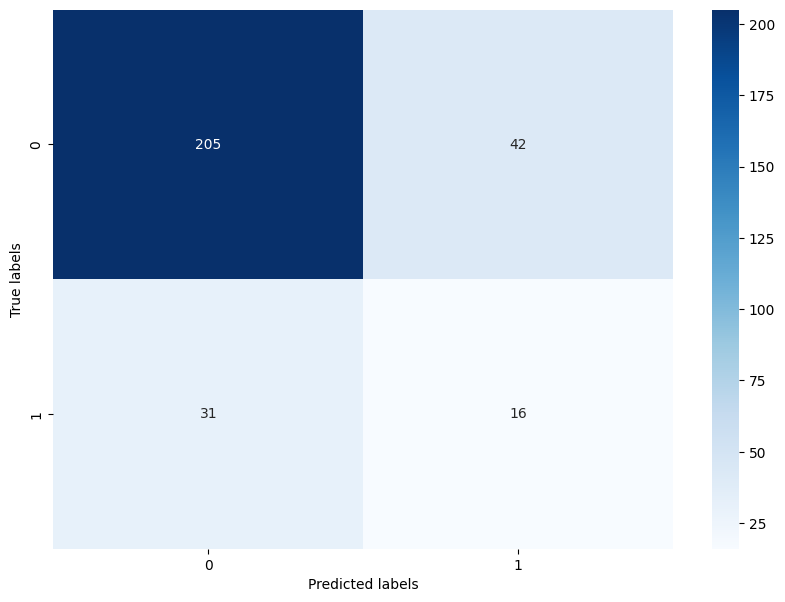

In [ ]:
dtree_cm = confusion_matrix(y_test, dtree_y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(dtree_cm, annot=True, fmt = 'g', cmap = 'Blues')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')
plt.show()

In [ ]:
print(dtree_cm)

[[205  42]
 [ 31  16]]


## GridSearch

In [ ]:
param_grid = {
    'criterion': ['gini'],
    'min_samples_split': [7,9,11,13,15],
    'min_samples_leaf': [3,5,7,9]
}

grid_search = GridSearchCV(dtree, param_grid, cv=5, verbose=2, n_jobs=1)
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
[CV] END criterion=gini, min_samples_leaf=3, min_samples_split=7; total time=   0.0s
[CV] END criterion=gini, min_samples_leaf=3, min_samples_split=7; total time=   0.0s
[CV] END criterion=gini, min_samples_leaf=3, min_samples_split=7; total time=   0.0s
[CV] END criterion=gini, min_samples_leaf=3, min_samples_split=7; total time=   0.0s
[CV] END criterion=gini, min_samples_leaf=3, min_samples_split=7; total time=   0.0s
[CV] END criterion=gini, min_samples_leaf=3, min_samples_split=9; total time=   0.0s
[CV] END criterion=gini, min_samples_leaf=3, min_samples_split=9; total time=   0.0s
[CV] END criterion=gini, min_samples_leaf=3, min_samples_split=9; total time=   0.0s
[CV] END criterion=gini, min_samples_leaf=3, min_samples_split=9; total time=   0.0s
[CV] END criterion=gini, min_samples_leaf=3, min_samples_split=9; total time=   0.0s
[CV] END criterion=gini, min_samples_leaf=3, min_samples_split=11; total time=   0.0s
[C

GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=1,
             param_grid={'criterion': ['gini'],
                         'min_samples_leaf': [3, 5, 7, 9],
                         'min_samples_split': [7, 9, 11, 13, 15]},
             verbose=2)

In [ ]:
best_params = grid_search.best_params_
best_cv_score = grid_search.best_score_
best_train_score = grid_search.score(x_train, y_train)
print("best parameter:", best_params)
print("best score of cross-validation:", best_cv_score)
print("best score of train:", best_train_score)

best parameter: {'criterion': 'gini', 'min_samples_leaf': 9, 'min_samples_split': 13}
best score of cross-validation: 0.8316336098088712
best score of train: 0.8962585034013606


In [ ]:
# train model using best parameter
dtree = DecisionTreeClassifier(criterion= best_params['criterion'],
                               min_samples_leaf = best_params['min_samples_leaf'],
                               min_samples_split= best_params['min_samples_split'],
                               random_state=42)

dtree.fit(x_train, y_train)

DecisionTreeClassifier(min_samples_leaf=9, min_samples_split=13,
                       random_state=42)

In [ ]:
dtree_y_pred = dtree.predict(x_test)

In [ ]:
print(classification_report(y_test, dtree_y_pred))

              precision    recall  f1-score   support

           0       0.89      0.89      0.89       247
           1       0.42      0.40      0.41        47

    accuracy                           0.82       294
   macro avg       0.65      0.65      0.65       294
weighted avg       0.81      0.82      0.81       294



# Decistion Tree Diagram

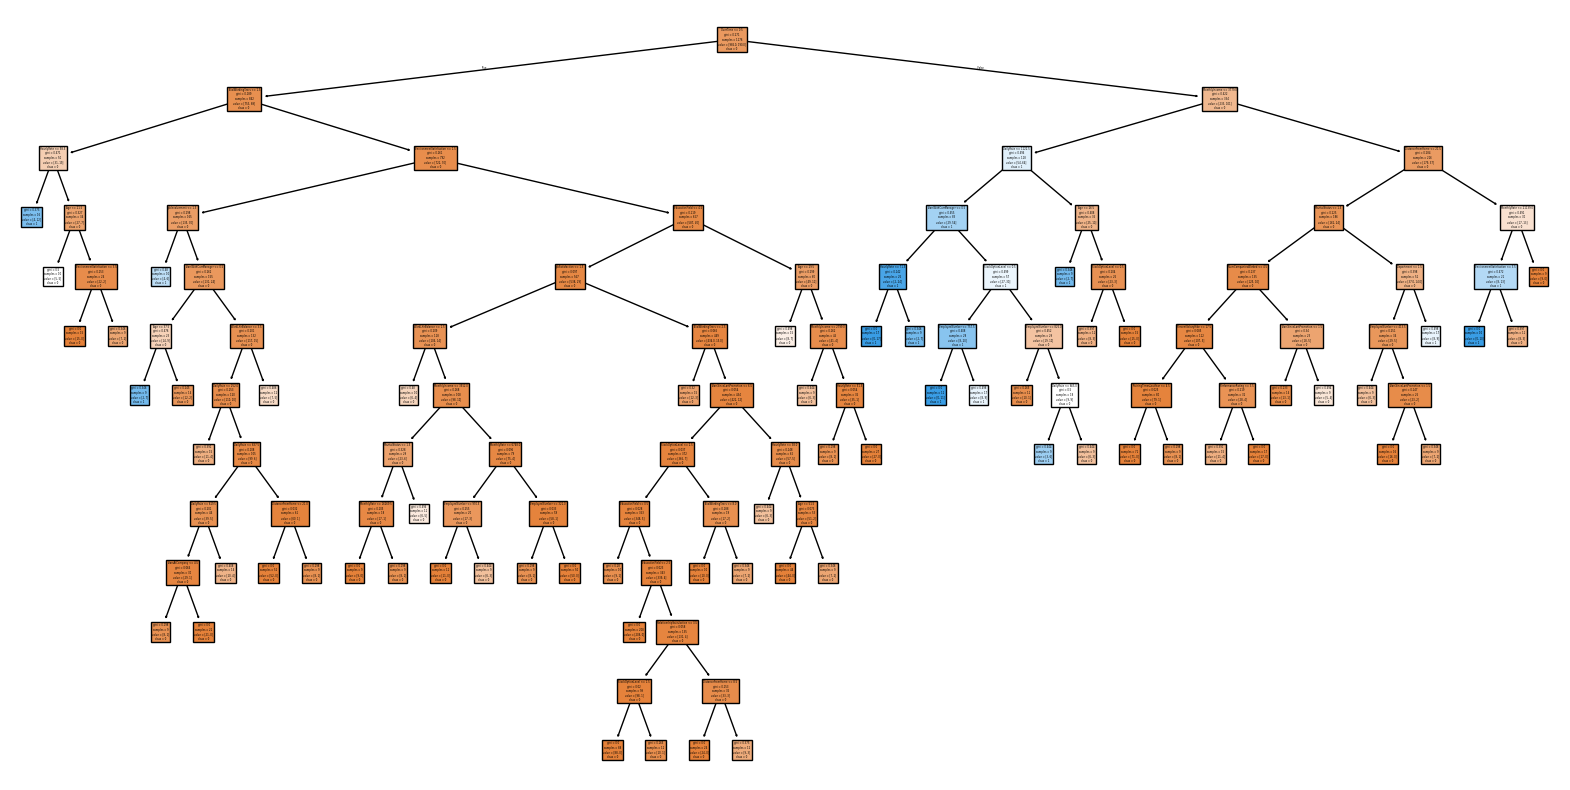

In [ ]:
from sklearn.tree import plot_tree
plt.figure(figsize=(20,10))
plot_tree(dtree.fit(x_train, y_train), feature_names=x.columns, class_names=['0', '1'], filled=True)
plt.show()

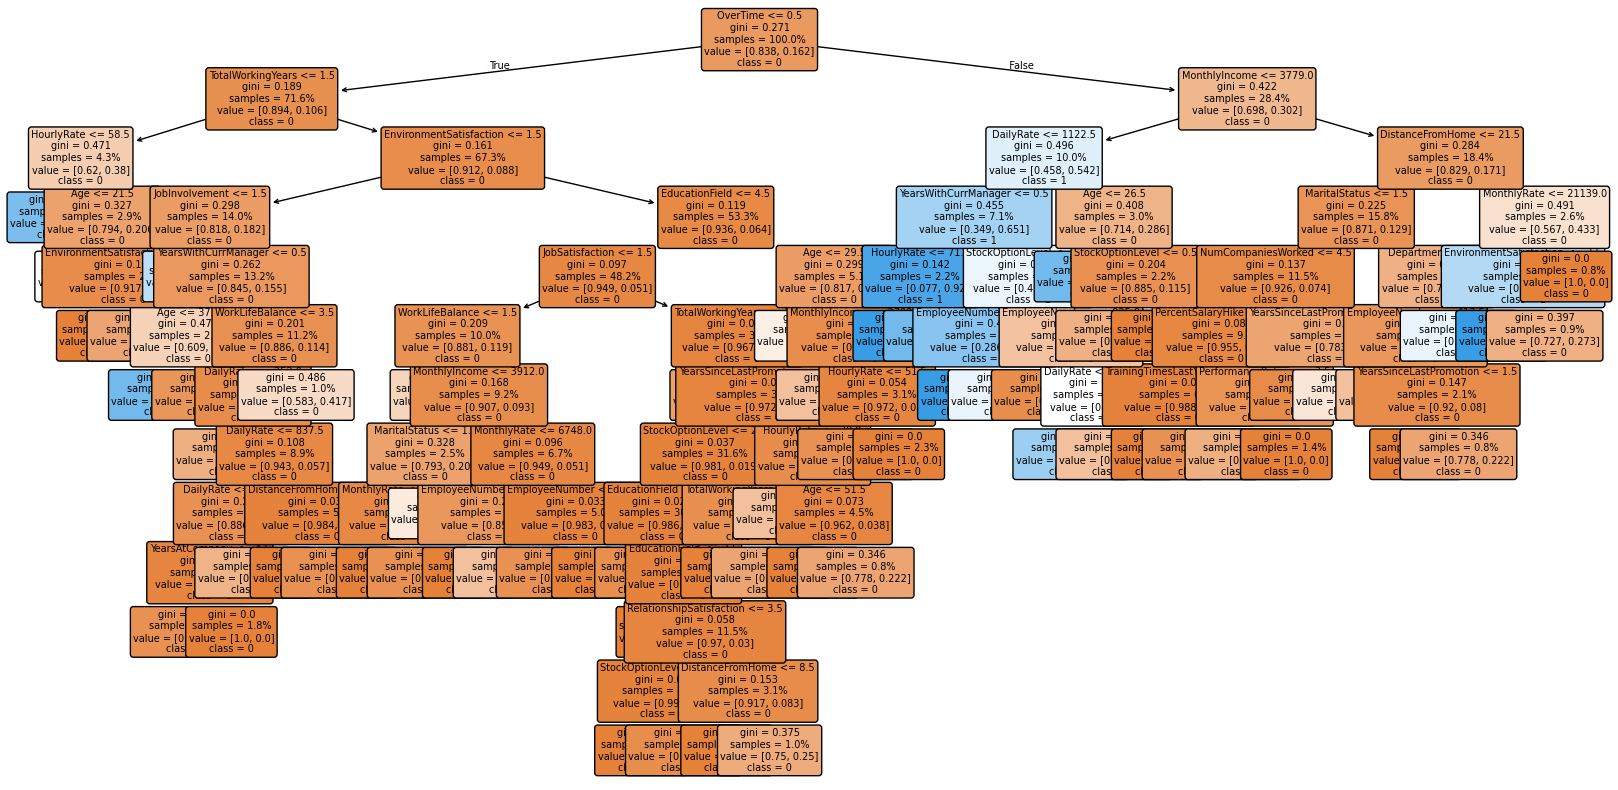

In [ ]:
# Up font size
plt.figure(figsize=(20,10))
plot_tree(dtree, feature_names=x.columns, class_names=['0', '1'], filled=True, rounded=True, fontsize = 7, proportion=True)
plt.savefig('decision_tree.png')
plt.show()


# Summarization of the Colab Notebook

This notebook demonstrates a comprehensive machine learning workflow for predicting employee attrition using a CART (Classification and Regression Trees) decision tree model.

## Key Steps

1. **Data Loading and Exploration:** The notebook begins by loading the employee attrition dataset and visualizing the data distribution through histograms.
2. **Data Preprocessing:** Categorical variables (Yes/No) are converted to numerical representations (1/0) using `LabelEncoder`. Constant features are removed, and categorical variables are further encoded.
3. **Train-Test Split:** The dataset is divided into training and testing sets to evaluate the model's performance on unseen data.
4. **Correlation Analysis:** Correlation matrices are visualized to identify features that are strongly associated with attrition.
5. **Decision Tree Classifier:** A `DecisionTreeClassifier` from scikit-learn is employed for building the CART decision tree.
6. **Cross-Validation:** 5-fold cross-validation is performed to assess the model's robustness and generalization ability.
7. **Model Evaluation:** The model's performance is evaluated using metrics such as precision, recall, F1-score, and the confusion matrix.
8. **Hyperparameter Tuning:** Grid Search with Cross-Validation is used to find the optimal hyperparameters for the decision tree, such as `min_samples_split` and `min_samples_leaf`.
9. **Model Training and Testing:** The model is re-trained using the best hyperparameters on the entire training dataset and evaluated on the test set.
10. **Decision Tree Visualization:** The trained decision tree is visualized using `plot_tree` to understand how the model makes decisions.


## Mathematical Concepts

The CART algorithm leverages concepts such as:

* **Gini Impurity:** A measure of impurity used to select the best feature for splitting the dataset at each node.
   ```
   Gini(S) = 1 - Σ (p_i)^2
   ```
   where `p_i` is the proportion of samples belonging to class `i` in the dataset `S`.
* **Information Gain:** The reduction in uncertainty achieved by splitting the dataset based on a particular feature.

## Conclusion

This notebook provides a practical example of how to build and evaluate a decision tree model for predicting employee attrition. By combining data preprocessing, model training, hyperparameter tuning, and visualization, the notebook offers valuable insights into the factors influencing employee attrition.